In [2]:
from astropy.io import fits

date = '2006-05-31'
instrument = 'WFC'
filter = 'F606W'

zeropoint = 26.501
exposure_time = 370

ff = fits.open('ngc6101/hlsp_hugs_hst_acs-wfc_ngc6101_f606w_v1_stack-0370s.fits')
print(ff)

In [3]:
im_data = ff[0].data
#print(im_data)

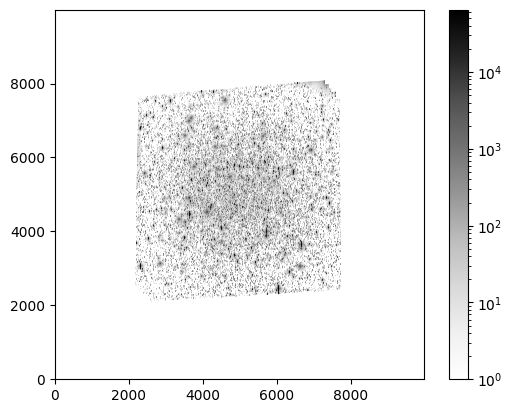

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

'''
plt.figure()
plt.imshow(im_data, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()
'''

In [5]:
ff.info()

Filename: ngc6101/hlsp_hugs_hst_acs-wfc_ngc6101_f606w_v1_stack-0370s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (10000, 10000)   float32   


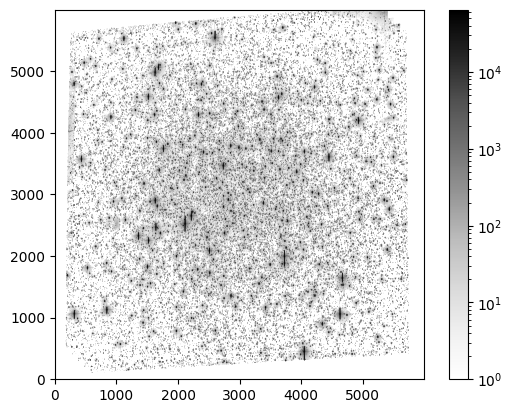

In [6]:
#section1 = im_data[2400:2600, 5650:5950]
#section1 = im_data[3000:3600, 5000:5600]
section1 = im_data[2000:8000, 2000:8000]

plt.figure()
plt.imshow(section1, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()


In [30]:
from astropy.stats import sigma_clipped_stats 

mean, median, std = sigma_clipped_stats(section1, sigma= 3.0)
print(mean, median, std)

3.7008193 0.0 12.62601


In [31]:
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std)
sources1 = daofind(section1 - median)
for col in sources1.colnames:
    if col not in ('id', 'npix'):
        sources1[col].info.format = '%.2f'

#sources1.pprint(max_width = 76)

In [32]:
import numpy as np 
from photutils.aperture import CircularAperture

positions = np.transpose((sources1['xcentroid'], sources1['ycentroid']))
apertures = CircularAperture(positions, r=5.0)

'''
plt.imshow(section1, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
'''

"\nplt.imshow(section1, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')\napertures.plot(color='red', lw=1.5, alpha=0.5);\n"

In [33]:
#only to remove certain dense spots

'''
mask = np.zeros(section1.shape, dtype=bool)
#mask[y:y, x:x] = True
mask[100:130, 0:10] = True  #approximately selecting coords that have multiple false positives
mask[140:180,400:430] = True  #approximately selecting coords that have multiple false positives
mask[340:360, 160:200] = True  #approximately selecting coords that have multiple false positives
mask[530:560, 300:340] = True  #approximately selecting coords that have multiple false positives

sources1 = daofind(section1-median, mask=mask)
xpix = sources1['xcentroid']
ypix = sources1['ycentroid']

positions = np.transpose((xpix, ypix))
apertures = CircularAperture(positions, r=5.0)

plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
'''

"\nmask = np.zeros(section1.shape, dtype=bool)\n#mask[y:y, x:x] = True\nmask[100:130, 0:10] = True  #approximately selecting coords that have multiple false positives\nmask[140:180,400:430] = True  #approximately selecting coords that have multiple false positives\nmask[340:360, 160:200] = True  #approximately selecting coords that have multiple false positives\nmask[530:560, 300:340] = True  #approximately selecting coords that have multiple false positives\n\nsources1 = daofind(section1-median, mask=mask)\nxpix = sources1['xcentroid']\nypix = sources1['ycentroid']\n\npositions = np.transpose((xpix, ypix))\napertures = CircularAperture(positions, r=5.0)\n\nplt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')\napertures.plot(color='red', lw=1.5, alpha=0.5);\n"

In [34]:
print(apertures)

Aperture: CircularAperture
positions: [[ 601.23292585,  105.13170249],
            [ 793.86003969,  110.53582388],
            [ 617.83624232,  114.91023031],
            ...,
            [4553.43812981, 5997.77300739],
            [4556.81602877, 5997.5573121 ],
            [5063.76309205, 5997.98499177]]
r: 5.0


In [35]:
from photutils.aperture import CircularAnnulus, ApertureStats, aperture_photometry

annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

'''
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
annulus_aperture.plot(color='yellow', lw=1.5, alpha=0.3);
'''

"\nplt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')\napertures.plot(color='red', lw=1.5, alpha=0.5);\nannulus_aperture.plot(color='yellow', lw=1.5, alpha=0.3);\n"

In [36]:
aper_stats = ApertureStats(section1, annulus_aperture)
bkg_mean = aper_stats.mean
aper_area = apertures.area_overlap(section1)
total_bkg = bkg_mean*aper_area
star_data = aperture_photometry(section1, apertures)

star_data['total_bkg'] = total_bkg
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'

star_data.pprint()

  id   xcenter   ycenter  aperture_sum total_bkg 
         pix       pix                           
----- --------- --------- ------------ ----------
    1 601.23293  105.1317    21379.258 -159.67764
    2 793.86004 110.53582    1675.4694 -189.50248
    3 617.83624 114.91023    1293.2413 -232.41374
    4 687.67611 115.19121    1447.3409 -122.10643
    5 698.27938 117.93587    851.51419  -89.75979
    6 717.08435 122.26333    519.14302 -402.11585
    7 858.29391  123.0228    2754.7269 -381.24954
    8 965.55864 122.57636    1070.2729 -195.65362
    9 893.80367 126.17926    588.19961 -212.23737
  ...       ...       ...          ...        ...
55623 4394.0337 5993.3762    5575.9181  300.51335
55624 4555.9055 5994.9502    2867402.6  13643.702
55625 4651.5671 5994.3764    3622.2847   1277.289
55626 4482.2695 5996.0202    5033.7862   12055.89
55627  4501.945 5996.4262    5101.5544  5379.6064
55628 4471.9768 5997.4648    58860.454  1346.1665
55629 4539.9554 5997.9016    12614.128  329291.27


In [37]:
from acstools import acszpt

#date = 2006-05-31 , 14:42:25
#exposure time = 35s
#filter = F606W
#instrument: Hubble Space Telescope: ACS-WFC

#date = '2006-05-31'
#instrument = 'WFC'
#filter = 'F606W'

q = acszpt.Query(date= date, detector = instrument)
zpt_table = q.fetch()
q_filter = acszpt.Query(date=date, detector=instrument,filt=filter)
filter_zpt=q_filter.fetch()

print(filter_zpt)


Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom electron cm2) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F606W   5919.7                    7.7949e-20   26.67  26.415  26.501


In [38]:
import math
#zeropoint = 26.501
#exposure_time = 370

magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint-(2.4*math.log10(abs(line[3]-line[4])/exposure_time)))
star_data['magnitude'] = magnitudes

star_data.pprint(max_lines=-1, max_width=-1)

  id   xcenter   ycenter  aperture_sum  total_bkg      magnitude     
         pix       pix                                               
----- --------- --------- ------------ ----------- ------------------
    1 601.23293  105.1317    21379.258  -159.67764 22.264945982198093
    2 793.86004 110.53582    1675.4694  -189.50248  24.81507066358684
    3 617.83624 114.91023    1293.2413  -232.41374 25.024388922452378
    4 687.67611 115.19121    1447.3409  -122.10643  24.99489197546101
    5 698.27938 117.93587    851.51419   -89.75979 25.527765604937514
    6 717.08435 122.26333    519.14302  -402.11585  25.55016810932172
    7 858.29391  123.0228    2754.7269  -381.24954 24.273389430309642
    8 965.55864 122.57636    1070.2729  -195.65362 25.218903761131628
    9 893.80367 126.17926    588.19961  -212.23737 25.696699000886795
   10 923.43258 126.83437    7173.1768   -295.0767  23.36895841889794
   11  592.7977  129.4908    1782.4095   1447.7773  26.60572165203481
   12 1017.4526 130.

16.762000405981226	36.723016894355986	23.234407181126738	2.2367929609910417


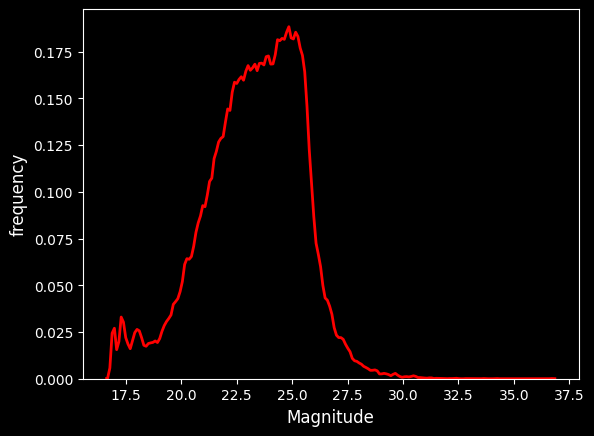

In [39]:
import seaborn as sns
import pandas as pd

mag_min = np.min(magnitudes)
mag_max = np.max(magnitudes)
mag_mid = np.mean(magnitudes)
mag_std = np.std(magnitudes)

print(f'{mag_min}\t{mag_max}\t{mag_mid}\t{mag_std}')

plt.style.use('dark_background')
mag_df = pd.DataFrame(magnitudes, columns=['Magnitude'])
fig, ax1 = plt.subplots()
ax1.set_ylabel('Density')
#sns.histplot(data=mag_df, x='Magnitude', binwidth=0.5, color='orange', ax=ax1)
#ax2 = ax1.twinx()

sns.kdeplot(data=mag_df, x='Magnitude', bw_adjust=0.25, color='red', ax=ax1)
ax1.set_ylabel('frequency')
ax1.grid(False)
plt.show()
